In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook

**Outline**

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data




## 1. Load and normalizing the CIFAR10 training and test datasets using torchvision

**torchvision** has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader

In [0]:
# apply a transform to the images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
type(trainset)


Files already downloaded and verified
Files already downloaded and verified


torchvision.datasets.cifar.CIFAR10

In [0]:
len(trainset), len(testset)

(50000, 10000)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
classes = {0:'plane',1:'car',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

## 2. Visualization of dataset

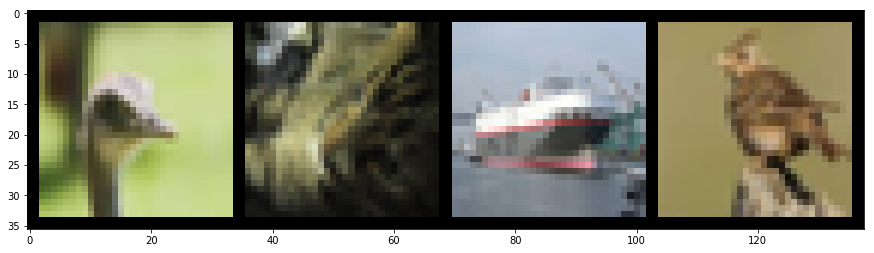

In [0]:
dataiter = iter(trainloader)
images,labels = dataiter.next()

def show_image(image):
  img = image.numpy()
  img = np.transpose(img, (1,2,0))
  plt.imshow(img)
  plt.show()

plt.figure(figsize=(15,15))
show_image(torchvision.utils.make_grid(images))

In [0]:
images[0].size()

torch.Size([3, 32, 32])

## 3. Convolution Neural Network

In [0]:
class Net(nn.Module):
  
  def __init__(self):
    
    super(Net,self).__init__()
    # partially connected convolution net
    self.conv1 = nn.Conv2d(3,6,5)  
    self.pool = nn.MaxPool2d(2,2)  # (N,6,28,)
    self.conv2 = nn.Conv2d(6,16,5) # 
    # fully connected neural net
    self.fc1 = nn.Linear(16*5*5,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
    
  def forward(self,X):
    x = self.pool(F.leaky_relu(self.conv1(X))) # (N,3,32,32) -> (N,6,28,28) -> (N,6,14,14) 
    x = self.pool(F.leaky_relu(self.conv2(x))) # (N,6,14,14) -> (N,16,10,10) -> (N,16,5,5)
    x = x.view(x.size(0),-1) # (N,16,5,5) -> (N, 16*5*5 = 400)
    x = F.leaky_relu(self.fc1(x)) # (N,400) * (400,120) -> (N,120)
    x = F.leaky_relu(self.fc2(x)) # (N,120) * (120,84) -> (N,84)
    x = self.fc3(x) # (N,84) * (84,10) -> (N,10)
    return x

**AttributeError**: 'NoneType' object has no attribute 'log_softmax'

https://github.com/pytorch/pytorch/issues/12436

In [0]:
net = Net()
net = net.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=0.001)

In [0]:
def return_accuracy(dataloader,model):
  total = 0
  correct = 0
  for images,labels in dataloader:
    images,labels = images.float().to(device), labels.long().to(device)
    prediction = model(images)
    total += labels.size(0)
    correct += torch.sum(torch.argmax(prediction,dim=1) == labels).item()
  return correct/total*100

In [0]:
epochs = 15

for epoch in range(epochs):
  print('Epoch:',epoch)
  iter_no = 0
  for i, data in enumerate(trainloader):  
    # get the inputs from every batch
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad() # zero the parameter gradients
    train_pred = net(inputs) # forward pass
    loss_train = loss_fn(train_pred,labels) # compute the loss
    loss_train.backward() # backward pass
    opt.step() # update the weight
        
    iter_no += 1
    
    if iter_no % 2000 == 0:
      train_accuracy = return_accuracy(trainloader,net)
      test_accuracy = return_accuracy(testloader,net)
      print('Accuracy on training set:',train_accuracy,' | Accuracy on test set:',test_accuracy)

Epoch: 0
Accuracy on training set: 37.26  | Accuracy on test set: 36.42
Accuracy on training set: 42.788  | Accuracy on test set: 42.8
Accuracy on training set: 43.278  | Accuracy on test set: 43.09
Accuracy on training set: 46.742  | Accuracy on test set: 46.150000000000006
Accuracy on training set: 47.052  | Accuracy on test set: 45.5
Accuracy on training set: 48.818  | Accuracy on test set: 47.370000000000005
Epoch: 1
Accuracy on training set: 49.712  | Accuracy on test set: 48.22
Accuracy on training set: 51.978  | Accuracy on test set: 49.76
Accuracy on training set: 53.635999999999996  | Accuracy on test set: 51.18000000000001
Accuracy on training set: 53.72  | Accuracy on test set: 50.870000000000005
Accuracy on training set: 54.70399999999999  | Accuracy on test set: 52.339999999999996
Accuracy on training set: 54.437999999999995  | Accuracy on test set: 51.92
Epoch: 2
Accuracy on training set: 56.354000000000006  | Accuracy on test set: 53.23
Accuracy on training set: 56.42200

### 3.1 Training for 15 epochs with adam algorithm

Epoch: 0
Accuracy on training set: 37.26  | Accuracy on test set: 36.42
Accuracy on training set: 42.788  | Accuracy on test set: 42.8
Accuracy on training set: 43.278  | Accuracy on test set: 43.09
Accuracy on training set: 46.742  | Accuracy on test set: 46.150000000000006
Accuracy on training set: 47.052  | Accuracy on test set: 45.5
Accuracy on training set: 48.818  | Accuracy on test set: 47.370000000000005

Epoch: 1
Accuracy on training set: 49.712  | Accuracy on test set: 48.22
Accuracy on training set: 51.978  | Accuracy on test set: 49.76
Accuracy on training set: 53.635999999999996  | Accuracy on test set: 51.18000000000001
Accuracy on training set: 53.72  | Accuracy on test set: 50.870000000000005
Accuracy on training set: 54.70399999999999  | Accuracy on test set: 52.339999999999996
Accuracy on training set: 54.437999999999995  | Accuracy on test set: 51.92

Epoch: 2
Accuracy on training set: 56.354000000000006  | Accuracy on test set: 53.23
Accuracy on training set: 56.422000000000004  | Accuracy on test set: 53.02
Accuracy on training set: 58.046  | Accuracy on test set: 54.49
Accuracy on training set: 58.48  | Accuracy on test set: 54.730000000000004
Accuracy on training set: 55.269999999999996  | Accuracy on test set: 52.33
Accuracy on training set: 59.384  | Accuracy on test set: 55.410000000000004

Epoch: 3
Accuracy on training set: 59.096000000000004  | Accuracy on test set: 54.98
Accuracy on training set: 61.114000000000004  | Accuracy on test set: 56.31
Accuracy on training set: 61.09  | Accuracy on test set: 56.379999999999995
Accuracy on training set: 61.45  | Accuracy on test set: 56.31
Accuracy on training set: 61.27  | Accuracy on test set: 56.42
Accuracy on training set: 61.80799999999999  | Accuracy on test set: 55.989999999999995

Epoch: 4
Accuracy on training set: 62.682  | Accuracy on test set: 56.95
Accuracy on training set: 60.88  | Accuracy on test set: 55.61000000000001
Accuracy on training set: 61.706  | Accuracy on test set: 56.21000000000001
Accuracy on training set: 63.548  | Accuracy on test set: 57.47
Accuracy on training set: 64.46600000000001  | Accuracy on test set: 57.84
Accuracy on training set: 64.998  | Accuracy on test set: 58.06

Epoch: 5
Accuracy on training set: 64.574  | Accuracy on test set: 57.47
Accuracy on training set: 63.176  | Accuracy on test set: 56.56
Accuracy on training set: 65.026  | Accuracy on test set: 58.28
Accuracy on training set: 64.672  | Accuracy on test set: 57.599999999999994
Accuracy on training set: 65.998  | Accuracy on test set: 58.29
Accuracy on training set: 64.62400000000001  | Accuracy on test set: 57.05

Epoch: 6
Accuracy on training set: 66.75  | Accuracy on test set: 58.43000000000001
Accuracy on training set: 66.778  | Accuracy on test set: 58.69
Accuracy on training set: 63.768  | Accuracy on test set: 56.37
Accuracy on training set: 67.44200000000001  | Accuracy on test set: 58.86
Accuracy on training set: 66.44200000000001  | Accuracy on test set: 57.69
Accuracy on training set: 67.032  | Accuracy on test set: 58.07

Epoch: 7
Accuracy on training set: 66.43599999999999  | Accuracy on test set: 57.769999999999996
Accuracy on training set: 66.89399999999999  | Accuracy on test set: 58.32000000000001
Accuracy on training set: 68.494  | Accuracy on test set: 58.620000000000005
Accuracy on training set: 67.834  | Accuracy on test set: 58.10999999999999
Accuracy on training set: 66.476  | Accuracy on test set: 57.31
Accuracy on training set: 69.176  | Accuracy on test set: 59.47

Epoch: 8
Accuracy on training set: 67.716  | Accuracy on test set: 58.58
Accuracy on training set: 67.634  | Accuracy on test set: 58.52
Accuracy on training set: 70.1  | Accuracy on test set: 59.519999999999996
Accuracy on training set: 69.072  | Accuracy on test set: 59.01
Accuracy on training set: 70.494  | Accuracy on test set: 59.29
Accuracy on training set: 69.788  | Accuracy on test set: 59.260000000000005

Epoch: 9
Accuracy on training set: 69.21000000000001  | Accuracy on test set: 58.620000000000005
Accuracy on training set: 70.904  | Accuracy on test set: 59.01
Accuracy on training set: 70.748  | Accuracy on test set: 59.0
Accuracy on training set: 65.508  | Accuracy on test set: 55.87
Accuracy on training set: 71.17  | Accuracy on test set: 59.29
Accuracy on training set: 70.332  | Accuracy on test set: 58.93000000000001

Epoch: 10
Accuracy on training set: 71.288  | Accuracy on test set: 59.03
Accuracy on training set: 67.97999999999999  | Accuracy on test set: 57.07
Accuracy on training set: 70.116  | Accuracy on test set: 58.440000000000005
Accuracy on training set: 71.358  | Accuracy on test set: 58.309999999999995
Accuracy on training set: 72.63  | Accuracy on test set: 59.74
Accuracy on training set: 71.41999999999999  | Accuracy on test set: 59.37

Epoch: 11
Accuracy on training set: 73.462  | Accuracy on test set: 59.699999999999996
Accuracy on training set: 70.55  | Accuracy on test set: 57.56
Accuracy on training set: 71.192  | Accuracy on test set: 57.940000000000005
Accuracy on training set: 70.75200000000001  | Accuracy on test set: 58.48
Accuracy on training set: 72.10600000000001  | Accuracy on test set: 58.45
Accuracy on training set: 72.792  | Accuracy on test set: 59.38

Epoch: 12
Accuracy on training set: 72.958  | Accuracy on test set: 58.9
Accuracy on training set: 73.26599999999999  | Accuracy on test set: 58.489999999999995
Accuracy on training set: 73.618  | Accuracy on test set: 58.589999999999996
Accuracy on training set: 72.58200000000001  | Accuracy on test set: 58.050000000000004
Accuracy on training set: 73.042  | Accuracy on test set: 58.379999999999995
Accuracy on training set: 73.492  | Accuracy on test set: 58.64

Epoch: 13
Accuracy on training set: 73.738  | Accuracy on test set: 58.440000000000005
Accuracy on training set: 73.954  | Accuracy on test set: 59.57
Accuracy on training set: 70.904  | Accuracy on test set: 57.32000000000001
Accuracy on training set: 73.458  | Accuracy on test set: 58.220000000000006
Accuracy on training set: 72.03399999999999  | Accuracy on test set: 57.26

Accuracy on training set: 69.234  | Accuracy on test set: 56.13
Epoch: 14
Accuracy on training set: 71.986  | Accuracy on test set: 58.02
Accuracy on training set: 74.424  | Accuracy on test set: 58.58
Accuracy on training set: 73.67  | Accuracy on test set: 57.599999999999994
Accuracy on training set: 73.92800000000001  | Accuracy on test set: 57.84
Accuracy on training set: 73.72999999999999  | Accuracy on test set: 58.36
Accuracy on training set: 72.69200000000001  | Accuracy on test set: 57.26

## 4. Test the network on the test data and per class accuracy

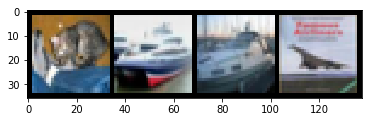

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

show_image(torchvision.utils.make_grid(images))

In [0]:
def print_accuracy(dataloader):

  total,correct = 0,0
  # iterate over the mini-batches
  
  with torch.no_grad():
    for data in dataloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      out = net(images)
      pred = torch.argmax(out,dim=1)
      total += labels.size(0)
      correct += torch.sum(pred==labels).item()
      
  print('Accuracy of the CNN model: %.2f %%' % (correct/total*100))
  
  
print_accuracy(trainloader)
print_accuracy(testloader)

Accuracy of the CNN model: 73.82 %
Accuracy of the CNN model: 58.80 %


In [0]:
def return_accuracy_per_class(dataloader):
  
  total,correct = 0,0
  # iterate over the mini-batches
  per_class_total = {}
  per_class_correct = {}
  per_class_accuracy = {}
  with torch.no_grad():
    for data in dataloader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      out = net(images)
      prediction = torch.argmax(out,dim=1)
      
      for i, label in enumerate(labels):
        try:
          per_class_total[label.item()] += 1
          per_class_correct[label.item()] += (prediction[i]==label).item()
        except:
          per_class_total.setdefault(label.item(),1) 
          per_class_correct.setdefault(label.item(),(prediction[i]==label).item())
    
    for i in classes.keys():
      per_class_accuracy.setdefault(classes[i],per_class_correct[i]/per_class_total[i]*100)
      
    return per_class_accuracy

In [0]:
accuracies_per_class = return_accuracy_per_class(trainloader)
for keys,values in accuracies_per_class.items():
  print(keys,':',values)

plane : 70.5
car : 89.60000000000001
bird : 57.699999999999996
cat : 55.34
deer : 62.4
dog : 68.30000000000001
frog : 86.5
horse : 79.7
ship : 83.56
truck : 84.56
